In [1]:
import cv2
import dlib
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torchvision import transforms
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from PIL import Image, ImageOps

import time

In [2]:
class EyeClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(6*6*32, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 6*6*32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
# Load pre-trained face detector
model_file = "./Pretrained Detectors/res10_300x300_ssd_iter_140000.caffemodel"
config_file = "./Pretrained Detectors/deploy.prototxt"
face_model = cv2.dnn.readNetFromCaffe(config_file, model_file)

# Load pre-trained landmark predictor
predictor = dlib.shape_predictor("./Pretrained Detectors/shape_predictor_68_face_landmarks.dat")

# Load CNN eye classifier
device = torch.device('cpu')
eye_model = EyeClassifier()
eye_model.load_state_dict(torch.load("./Saved Models/model_DataAug3.pt", map_location = device))
eye_model.eval()

EyeClassifier(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [4]:
# Locates bounding box for a single face
def detect_face(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)     
    blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

    face_model.setInput(blob)
    detections = face_model.forward()

    (x1, y1, x2, y2) = 0, 0, 0, 0
    max_confidence = 0

    for i in range(detections.shape[2]):                          
        confidence = detections[0, 0, i, 2]

        if confidence > 0.5 and confidence > max_confidence:      # Only considers predictions with > 0.5 confidence
            (h, w) = img.shape[:2]
            x1 = int(detections[0, 0, i, 3] * w)
            y1 = int(detections[0, 0, i, 4] * h)
            x2 = int(detections[0, 0, i, 5] * w)
            y2 = int(detections[0, 0, i, 6] * h)

            max_confidence = confidence                           # If multiple faces are detected, only return the one with highest confidence

    return dlib.rectangle(x1, y1, x2, y2), max_confidence


# Locates bounding box for a single eye
def detect_eye(img, face):
    landmarks = predictor(img, face)

    if landmarks.num_parts == 0:
        return (0, 0, 0, 0), False
    
    """ Below is some random math I came up with to turn LEFT eye landmarks into a square box, feel free to change"""
    x1 = landmarks.part(17).x                   
    x2 = landmarks.part(21).x
    d = abs(x2-x1)
    k = d * 0.15

    x1 = x1 - int(k/2)
    x2 = x2 + int(k/2)
    y1 = landmarks.part(19).y - int(k/2)
    y2 = y1 + int(d+k)

    return (x1, y1, x2, y2), True

In [5]:
# Prepares an image for CNN eye classifier
def preprocess(img):
    t = transforms.Compose([transforms.Resize([32, 32]), 
                            transforms.ToTensor()]) 
                            
    img = Image.fromarray(img).convert("L")
    img = ImageOps.equalize(img)
    img = t(img)

    return img


# Predicts eye state given a single 1x24x24 tensor
def predict_eye_state(img):
    outputs = eye_model(img.unsqueeze(0))
    prob = F.softmax(outputs, dim = 1)
    pred = outputs.argmax(dim = 1).item()

    #print(f"Probabilities: ({prob[0][0]}, {prob[0][1]})")
    #print("Prediction:", pred)

    return pred

In [6]:
def _map(x, in_min, in_max, out_min, out_max):
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

def perclos_to_kss(x):
    if x <= 0.075:
        return int(_map(x, 0, 0.075, 1, 5))
    if x <= 0.15:
        return int(_map(x, 0.075, 0.15, 6, 7))
    else:
        return int(_map(x, 0.15, 1, 8, 9))

In [13]:
def detection_kss(vid_path, kss_path):
    '''
    Takes in the path of the video, path of the kss file. 
    '''
    cap = cv2.VideoCapture(vid_path)    
    #cap = cv2.VideoCapture("./Datasets/X/04/5.mp4")   
    #cap = cv2.VideoCapture(0)

    perclos_list = []
    closed_list = []

    cap.set(cv2.CAP_PROP_POS_FRAMES, int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 190 * cap.get(cv2.CAP_PROP_FPS))

    while cap.isOpened():
        ret, frame = cap.read()     # return status and image
        if not ret:
            print("Can't retreive frame")
            break

        # Face detection
        face, confidence = detect_face(frame)

        if confidence > 0:
            # Eye detection
            (x1, y1, x2, y2), eye_found = detect_eye(frame, face)

            if eye_found:
                # Eye state classification
                eye = frame[y1:y2, x1:x2]
                eye = preprocess(eye)
                eye_state = predict_eye_state(eye)
                perclos_list.append(eye_state)

                if(eye_state == 0):
                    cv2.putText(frame, "Closed", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
                    closed_list.append(eye_state)

                if(len(perclos_list) == 5400):
                    break

            # Rectangle visuals
            #cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 1)
            #cv2.rectangle(frame, (face.left(), face.top()), (face.right(), face.bottom()), (255, 0, 0), 2)
            #confidence_txt = "{:.2f}%".format(confidence * 100)
            #cv2.putText(frame, confidence_txt, (face.left(), face.top()), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 1)
        # Display frame
        #cv2.imshow("img", frame)
        #print(len(closed_list))

        # Exit window using "q" key
        if cv2.waitKey(1) == ord("q"):
            break
    
    cap.release()
    cv2.destroyAllWindows()

    # add kss if and else and attach the kss function
    print("Total number of frames: ", len(perclos_list))
    print("Closed eyes in the list: ", len(closed_list))
    perclos_deno = len(perclos_list)
    perclos_nume = len(closed_list)
    perclos_value = (perclos_nume / perclos_deno)


    f = open(kss_path, "r")
    list1 = []
    string = f.read()
    string_mod = string.replace("\n", ",")
    list1 = string_mod.split(",")
    for i in range(len(list1)):
        list1[i] = list1[i].split(" ")

    
    # video_number = vid_path[]
    if vid_path[-8] == "/":
        per_index = int(vid_path[-7])-1
        vid_index = int(vid_path[-5])-1
    else:
        per_index = 9+int(vid_path[-7])
        vid_index = int(vid_path[-5])-1

    # Metrics
    kss = int(list1[per_index][vid_index])
    prediction = perclos_to_kss(perclos_value) 

    return kss, prediction


In [ ]:
video_69 = "./Datasets/DROZY/videos_i8/1-1.mp4"
kss_69 = "./Datasets/DROZY/KSS.txt"

kss, prediction = detection_kss(video_69, kss_69)

# loop thru all the videos in drozy and output the perclos values in a list. Compare error with corresponding KSS values and plot

In [14]:
video_dir = "./Datasets/DROZY/videos_i8/"
kss_path = "./Datasets/DROZY/KSS.txt"

videos_1 = os.listdir(video_dir)

result = []

for i, video in enumerate(videos_1):
    video_path = video_dir + video
    kss, prediction = detection_kss(video_path, kss_path)
    result.append((kss, prediction))

    print(f"Video {i} finished")
    print(f"\tKSS: {kss}, Prediction: {prediction}\n")


Total number of frames:  5400
Closed eyes in the list:  325
Video 0 finished
	KSS: 3, Prediction: 4

Can't retreive frame
Total number of frames:  2850
Closed eyes in the list:  231
Video 1 finished
	KSS: 6, Prediction: 6

Can't retreive frame
Total number of frames:  2784
Closed eyes in the list:  377
Video 2 finished
	KSS: 7, Prediction: 6

Total number of frames:  5400
Closed eyes in the list:  438
Video 3 finished
	KSS: 3, Prediction: 6

Total number of frames:  5400
Closed eyes in the list:  563
Video 4 finished
	KSS: 7, Prediction: 6

Total number of frames:  5400
Closed eyes in the list:  379
Video 5 finished
	KSS: 4, Prediction: 4

Total number of frames:  5400
Closed eyes in the list:  481
Video 6 finished
	KSS: 7, Prediction: 6

Total number of frames:  5400
Closed eyes in the list:  691
Video 7 finished
	KSS: 7, Prediction: 6

Total number of frames:  5400
Closed eyes in the list:  311
Video 8 finished
	KSS: 2, Prediction: 4

Total number of frames:  5400
Closed eyes in the 

<AxesSubplot:xlabel='Video', ylabel='Karolinska Sleepiness Scale'>

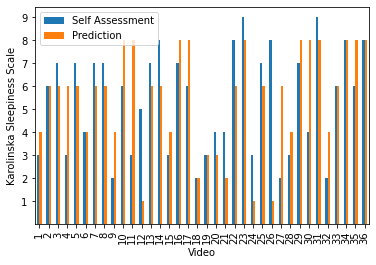

In [45]:
ks = []
ps = []
err = []
wrongs = 0

n = 36
x = list(range(1, n+1))
y = list(range(1, 10))

for i,(kss, pred) in enumerate(result):
    if i == n:
        break

    ks.append(kss)
    ps.append(pred)
    err.append(abs((pred-kss)))

    if kss <= 5:
        if pred > 5:
            wrongs += 1
    elif kss <= 7:
        if pred < 6 or pred > 7:
            wrongs += 1
    else:
        if pred < 8:
            wrongs += 1

# Plot prediction vs self-assessment
df = pd.DataFrame(list(zip(x, ks, ps)), columns = ["Video", "Self Assessment", "Prediction"])
df.set_index("Video", inplace = True)

fig, ax = plt.subplots()
ax.set_ylabel("Karolinska Sleepiness Scale")
ax.set_yticks(y)
ax.set_xticks(x)
df.plot.bar(ax = ax)

In [29]:
print("Classification Error Rate:", wrongs/n)

Classification Error Rate: 0.3333333333333333


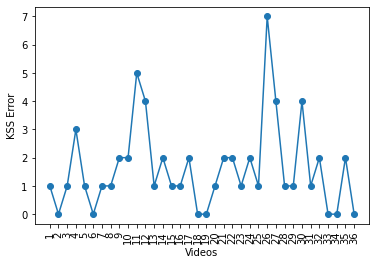

1.6388888888888888


In [46]:
# Plot error
plt.plot(x, err, marker = "o")
plt.xticks(x, rotation = "vertical")
plt.xlabel("Videos")
plt.ylabel("KSS Error")
plt.show()

avg_err = sum(err)/n
print(avg_err)